In [1]:
import BlackScholes as bs
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ImpliedDrift as iD
import time
import pymc as pm
import pytensor.tensor as pt
import variance_curve as vc
import Quintic

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
dates = np.array(["23_01_23.csv", "24_01_23.csv", "25_01_23.csv", "26_01_23.csv", "27_01_23.csv",
                  "30_01_23.csv", "06_02_23.csv", "13_02_23.csv", "21_02_23.csv"])

spot = np.array(pd.read_csv("spot.csv").Spot).flatten()

moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])

index = 0

parameters = pd.read_csv("quintic_stability_parameters3.csv")
rho,H,eps,a0,a1,a3,a5 = np.array(parameters.iloc[index])
a_k = np.array([a0,a1,a3,a5])

data = pd.read_csv(dates[index]); S0 = spot[index];
K = S0 * moneyness / 100

if index:
    maturities = np.array(data.Tenor).flatten()
    IV = np.array(data.drop(columns = ['Date', 'Tenor']))/100.

else:
    maturities = np.array(data['Exp Date']).flatten()
    IV = np.array(data.drop(columns = 'Exp Date'))/100.
    
IV = IV[maturities <= 180/365]
maturities = maturities[maturities <= 180/365]

In [3]:
nr = len(maturities); nc = len(K)
N = 5000; n = 300;
T = maturities[-1]; steps = np.ceil(n*maturities/T).astype(int);
np.random.seed(index)
w = np.concatenate((np.zeros([1,N*2]), Quintic.dW(n, N)))

In [4]:
r = iD.r(maturities, index); q = iD.q(maturities, index);

true_price = np.zeros([nr,nc])

for i in range(nr):
    tau = maturities[i]
    for j in range(nc):
        true_price[i,j] = bs.BSCall(S0, K[j], tau, r[i], q[i], IV[i,j])
true_price = true_price.flatten()

In [5]:
def f(rho, H, eps, size = None):
    return Quintic.global_reduction(rho, H, eps, T, a_k, S0, K, n, N, w, steps, maturities, index).flatten()

In [6]:
%%timeit
f(-0.8, 0, 0.001)

403 ms ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
def f(rng, rho, H, eps, size = None):
    return Quintic.global_reduction(rho, H, eps, T, a_k, S0, K, n, N, w, steps, maturities, index).flatten()

In [8]:
start_time = time.time()

with pm.Model() as model_lv:
    
    rho = pm.Uniform("rho", lower = -1, upper = -0.1)
    H = pm.Uniform("H", lower = 0, upper = 0.15)
    eps = pm.Uniform("eps", lower = 0.001, upper = 0.25)

    sim = pm.Simulator("sim", f, params = (rho, H, eps), epsilon = 20, observed = true_price)

    idata_lv = pm.sample_smc(draws = 2000, chains = 4, progressbar=False)
    
print(f'Elapsed time: {time.time()-start_time: .2f}s')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
C:\Users\super\AppData\Local\Programs\Python\Python39\lib\site-packages\arviz\data\base.py:221: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Elapsed time:  39191.46s


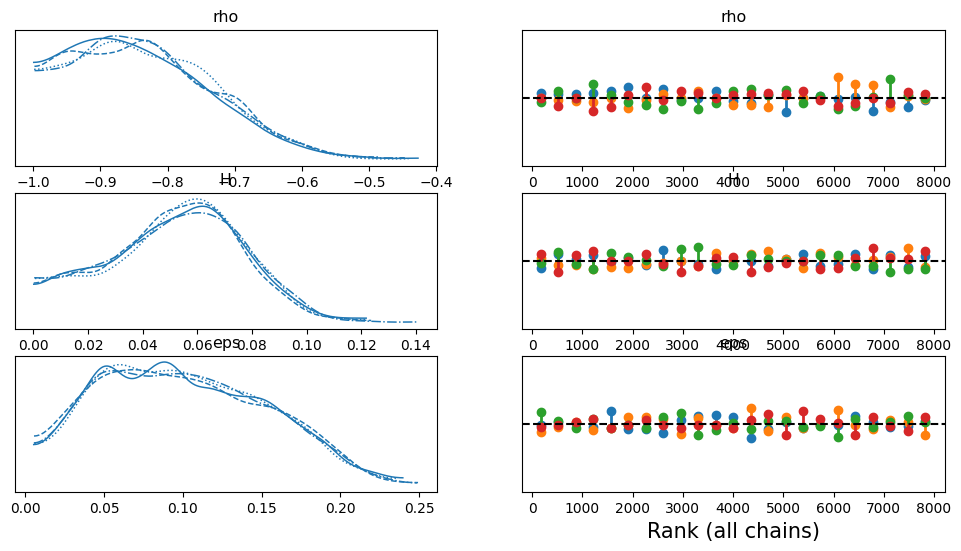

In [9]:
az.plot_trace(idata_lv, kind="rank_vlines");

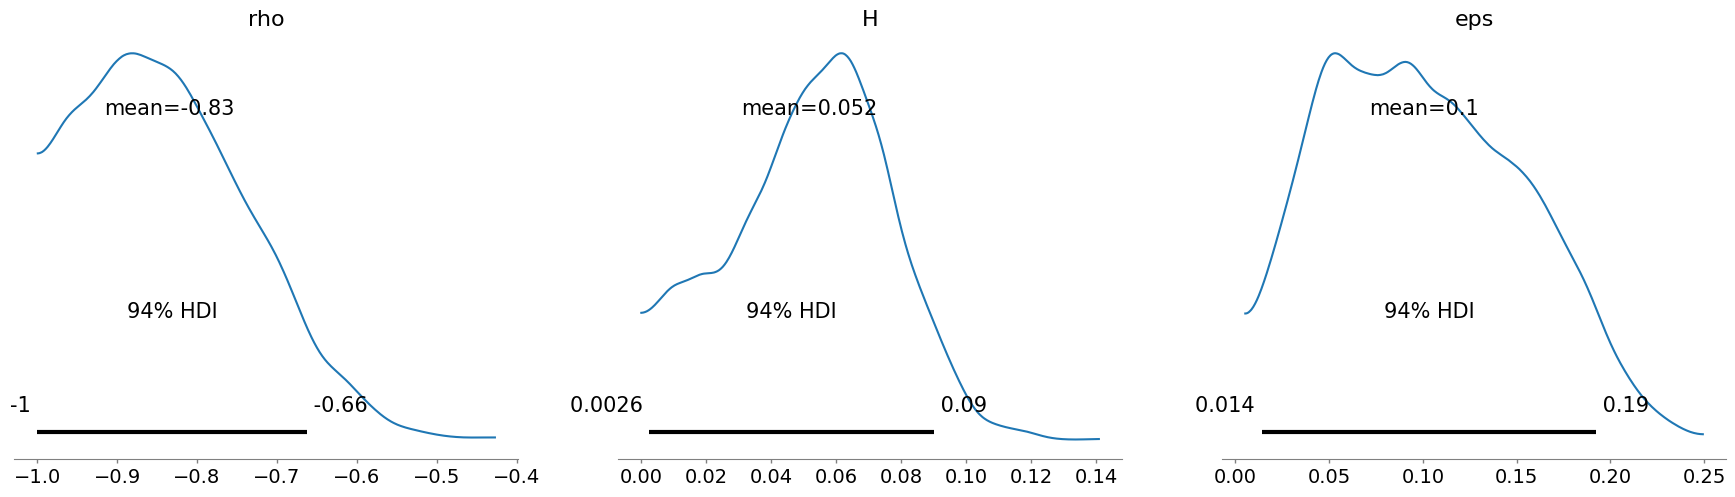

In [10]:
az.plot_posterior(idata_lv);

In [11]:
rho = np.array(pd.DataFrame(idata_lv.posterior.rho)).flatten()
H = np.array(pd.DataFrame(idata_lv.posterior.H)).flatten()
eps = np.array(pd.DataFrame(idata_lv.posterior.eps)).flatten()

Rho: -0.8814512133267915


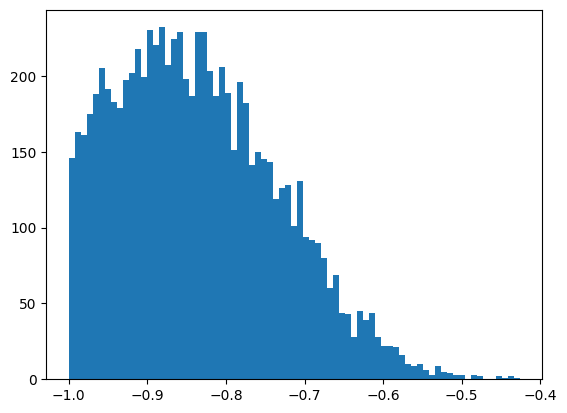

In [12]:
a = plt.hist(rho, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = x[np.argmax(y)]
print("Rho:", x_max)

H: 0.05919652155715627


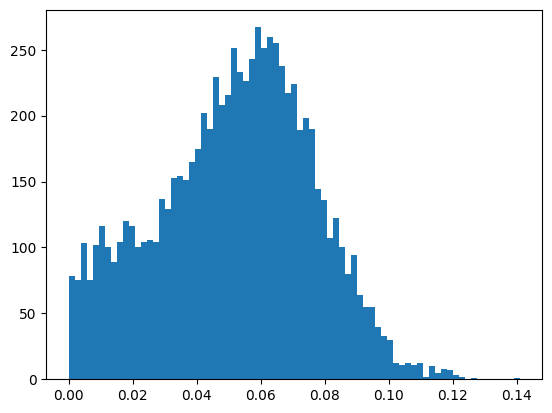

In [13]:
a = plt.hist(H, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = x[np.argmax(y)]
print("H:", x_max)

Eps: 0.052355852098365574


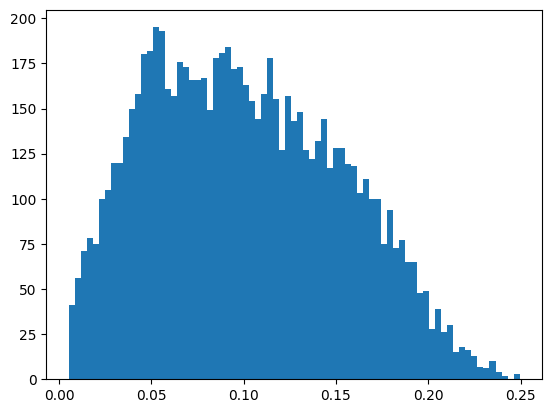

In [14]:
a = plt.hist(eps, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = x[np.argmax(y)]
print("Eps:", x_max)

In [15]:
data = pd.concat([pd.DataFrame(rho, columns = ["rho"]), pd.DataFrame(H, columns = ["H"])], axis = 1)
data = pd.concat([data, pd.DataFrame(eps, columns = ["eps"])], axis = 1)
data.to_csv("quintic_bayesian_data2.csv", index = False)

In [16]:
data

,rho,H,eps
0,-0.950047,0.061604,0.099005
1,-0.780694,0.053825,0.114207
2,-0.970025,0.071793,0.048691
3,-0.611850,0.063239,0.205129
4,-0.779811,0.000657,0.016877
...,...,...,...
7995,-0.869169,0.095799,0.053407
7996,-0.839673,0.045359,0.044429
7997,-0.705258,0.064941,0.052040
7998,-0.844695,0.019516,0.138194
